In [38]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from PIL import Image
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, Gain, PitchShift, RoomSimulator
from tqdm import tqdm
import tensorflow as tf
import IPython.display as ipd

In [39]:
metadata = pd.read_csv('./ESC-50-master/meta/esc50.csv')
metadata

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [40]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [41]:
#set aside 20% of images for testing, ensuring that the dataset is balanced by stratified sampling
test_df = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(8))
train_df = metadata[~metadata.isin(test_df)].dropna()

train_audio = []
train_labels = []
test_audio = []
test_labels = []

for i in tqdm(train_df.index):
  filename = train_df['filename'][i]
  label = train_df['target'][i]
  y,sr = librosa.load('ESC-50-master/audio/'+filename)
  train_audio.append(y)
  train_labels.append(label)

for i in tqdm(test_df.index):
  filename = test_df['filename'][i]
  label = test_df['target'][i]
  file_path = 'C:/Users/MoeSleazy/Downloads/Environmental-Sound-Classification-main/Environmental-Sound-Classification-main/ESC-50-master/audio/' + filename
  y, sr = librosa.load(file_path)  
  test_audio.append(y)
  test_labels.append(label)

     

C:\Users\MoeSleazy\AppData\Local\Temp\ipykernel_5720\454172983.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = metadata.groupby('target', group_keys=False).apply(lambda x: x.sample(8))
100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 537.64it/s]


In [42]:
my_dict = {}
for i in range(len(metadata)):
    my_dict[metadata['target'][i]] = metadata['category'][i]
my_dict


{0: 'dog',
 14: 'chirping_birds',
 36: 'vacuum_cleaner',
 19: 'thunderstorm',
 30: 'door_wood_knock',
 34: 'can_opening',
 9: 'crow',
 22: 'clapping',
 48: 'fireworks',
 41: 'chainsaw',
 47: 'airplane',
 31: 'mouse_click',
 17: 'pouring_water',
 45: 'train',
 8: 'sheep',
 15: 'water_drops',
 46: 'church_bells',
 37: 'clock_alarm',
 32: 'keyboard_typing',
 16: 'wind',
 25: 'footsteps',
 4: 'frog',
 3: 'cow',
 27: 'brushing_teeth',
 43: 'car_horn',
 12: 'crackling_fire',
 40: 'helicopter',
 29: 'drinking_sipping',
 10: 'rain',
 7: 'insects',
 26: 'laughing',
 6: 'hen',
 44: 'engine',
 23: 'breathing',
 20: 'crying_baby',
 49: 'hand_saw',
 24: 'coughing',
 39: 'glass_breaking',
 28: 'snoring',
 18: 'toilet_flush',
 2: 'pig',
 35: 'washing_machine',
 38: 'clock_tick',
 21: 'sneezing',
 1: 'rooster',
 11: 'sea_waves',
 42: 'siren',
 5: 'cat',
 33: 'door_wood_creaks',
 13: 'crickets'}

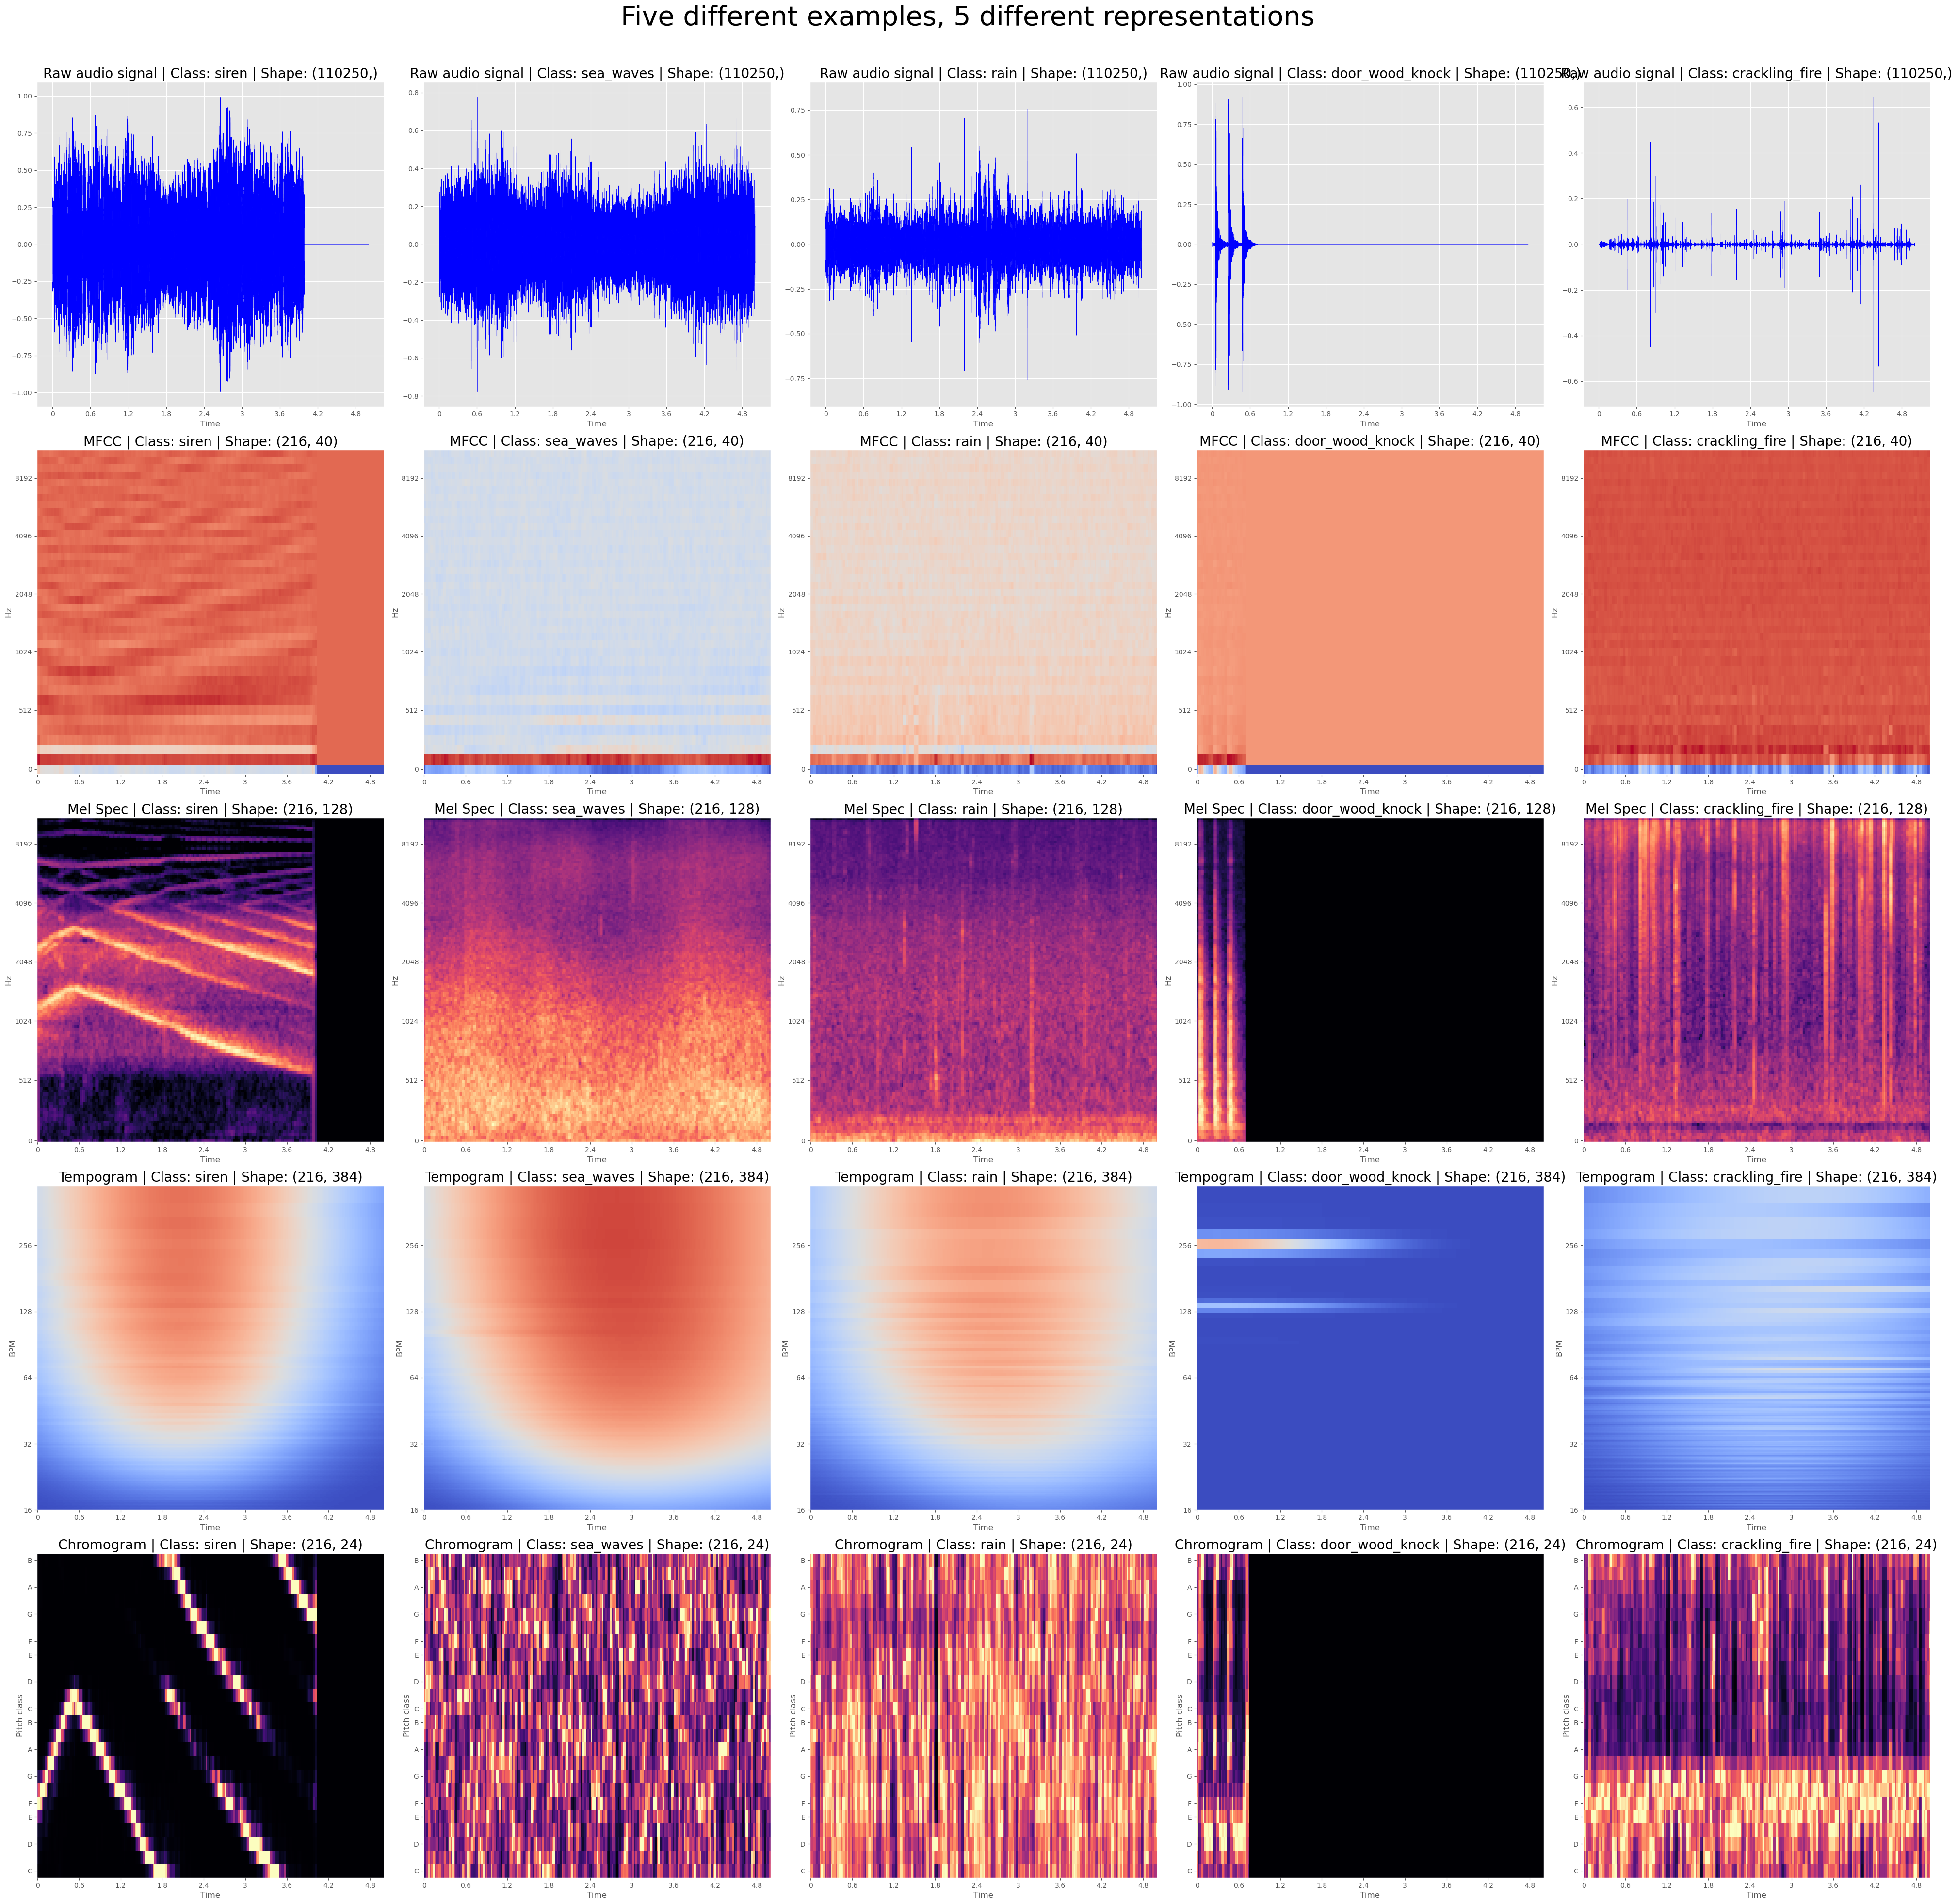

In [43]:
import matplotlib.pyplot as plt

samples = metadata.sample(5)[['filename','category']]
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(40,40))
for i, idx in enumerate(samples.index):
    # Load the audio file and grab the category
    filename = 'C:/Users/MoeSleazy/Downloads/Environmental-Sound-Classification-main/Environmental-Sound-Classification-main/ESC-50-master/audio/'+metadata['filename'][idx]
    category = metadata['category'][idx]
    y, sr = librosa.load(filename)
    # Plot the wave
    librosa.display.waveshow(y, sr=sr, ax=ax[0][i], color='blue')  # Set color manually
    # Plot the MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=2048, hop_length=512, n_mfcc=40)
    librosa.display.specshow(mfcc, sr=sr, ax=ax[1][i], y_axis='mel', x_axis='time')
    # Plot the Mel Spectrogram
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(melspec, sr=sr, ax=ax[2][i], y_axis='mel', x_axis='time')
    # Plot the Tempogram
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=512, norm=None)
    librosa.display.specshow(tempogram, sr=sr, hop_length=512, x_axis='time', y_axis='tempo', ax=ax[3][i])
    # Plot the Chromagram
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512, n_chroma=24)
    librosa.display.specshow(chromagram, sr=sr, hop_length=512, x_axis='time', y_axis='chroma', ax=ax[4][i])
    ax[0][i].set_title(f"Raw audio signal | Class: {category} | Shape: {y.shape}", fontsize=20)
    ax[1][i].set_title(f"MFCC | Class: {category} | Shape: {mfcc.T.shape}", fontsize=20)
    ax[2][i].set_title(f"Mel Spec | Class: {category} | Shape: {melspec.T.shape}", fontsize=20)
    ax[3][i].set_title(f"Tempogram | Class: {category} | Shape: {tempogram.T.shape}", fontsize=20)
    ax[4][i].set_title(f"Chromogram | Class: {category} | Shape: {chromagram.T.shape}", fontsize=20)

fig.suptitle('Five different examples, 5 different representations\n\n', fontsize=40)
fig.tight_layout()
fig.savefig('5_examples.png')


In [44]:
audio_augment = Compose([
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.15, p=0),
        #PitchShift(min_semitones=-6, max_semitones=6, p=1),
        TimeStretch(min_rate=.75, max_rate=1.25,p=1),
        #Gain(min_gain_in_db=12, max_gain_in_db=12, p=1),
        #RoomSimulator(p=1, leave_length_unchanged=True)
])
     

In [45]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#callbacks
rlronp=ReduceLROnPlateau(monitor="val_accuracy",factor=0.5, patience=2, verbose=1)
estop=EarlyStopping(monitor="val_accuracy", patience=6, verbose=1, restore_best_weights=True)

def build_model(input_shape):
  # create the model
  model = Sequential()

  # add layers
  model.add(BatchNormalization(axis=1, input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation="softmax"))

  # compile the model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [46]:
def run_experiment(make_spec, augment=0):

  images_train = np.array([make_spec(clip,sr) for clip in train_audio])
  images_test =  np.array([make_spec(clip,sr) for clip in test_audio])

  num_augmented = int(len(train_audio)*augment)
  if augment:
    #genreate augmented images from the first num_augmented clips and concatenate them to the train images
    augmented_img = np.array([make_spec(audio_augment(samples=clip, sample_rate=sr),sr) for clip in train_audio[:num_augmented]])
    images_train = np.concatenate((images_train, augmented_img))


  #expected shape (num_examples, spec freq range, spec time, 1)
  shape_train = (len(images_train), images_train[0].shape[0], images_train[0].shape[1], 1)
  shape_test = (len(images_test), images_train[0].shape[0], images_train[0].shape[1], 1)
  images_train = np.resize(images_train, shape_train)
  images_test = np.resize(images_test, shape_test)

  labels_train = np.array(train_labels+train_labels[:num_augmented])
  labels_test = np.array(test_labels)

  model = build_model(shape_train[1:])

  model.summary()

  history = model.fit(images_train, labels_train, epochs=40, validation_data=(images_test,labels_test), callbacks=[rlronp,estop])

  return history, estop
     


In [47]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#callbacks
rlronp=ReduceLROnPlateau(monitor="val_accuracy",factor=0.5, patience=2, verbose=1)
estop=EarlyStopping(monitor="val_accuracy", patience=8, verbose=1, restore_best_weights=True)

def build_model(input_shape):
  # create the model
  model = Sequential()

  # add layers
  model.add(BatchNormalization(axis=1, input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=3, activation="relu", padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation="softmax"))

  # compile the model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [48]:
def plot_curves(history, estop=None):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_ylim([0, 1])
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')

  if estop:
    best_epoch = estop.stopped_epoch-estop.patience
    ax[0].plot(best_epoch, history.history['accuracy'][best_epoch], marker='*', color='gold',ms=10)
    ax[0].plot(best_epoch, history.history['val_accuracy'][best_epoch], marker='*', color='gold',ms=10)
    ax[1].plot(best_epoch, history.history['loss'][best_epoch], marker='*', color='gold',ms=10)
    ax[1].plot(best_epoch, history.history['val_loss'][best_epoch], marker='*', color='gold',ms=10)
    ax[0].legend(['Train', 'Test', 'Best weights'], loc='upper left')
    ax[1].legend(['Train', 'Validation','Best weights'], loc='upper left')
  else:
    ax[0].legend(['Train', 'Test'], loc='upper left')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
  return fig

In [49]:


# Experiment #1: Mel Spectrograms, No augmentation

def generate_mel_spectrogram(y,sr):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    return melspec

#history_ex_1, estop_ex_1 = run_experiment(generate_mel_spectrogram, augment=0)
#plot_curves(history_ex_1, estop=estop_ex_1).show()

C:\Users\MoeSleazy\anaconda3\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 128, 216, 1)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 216, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 108, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 108, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 54, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 27, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 13, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26624)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,816,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          12,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,789,106 (29.71 MB)

 Trainable params: 7,788,850 (29.71 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 845ms/step - accuracy: 0.0386 - loss: 3.8728 - val_accuracy: 0.0425 - val_loss: 5.2727 - learning_rate: 0.0010
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 841ms/step - accuracy: 0.1018 - loss: 3.4373 - val_accuracy: 0.1450 - val_loss: 3.2975 - learning_rate: 0.0010
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 842ms/step - accuracy: 0.2434 - loss: 2.7028 - val_accuracy: 0.3475 - val_loss: 2.4121 - learning_rate: 0.0010
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 847ms/step - accuracy: 0.3506 - loss: 2.2628 - val_accuracy: 0.4200 - val_loss: 2.0703 - learning_rate: 0.0010
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 836ms/step - accuracy: 0.4574 - loss: 1.9571 - val_accuracy: 0.4875 - val_loss: 1.7968 - learning_rate: 0.0010
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 846ms/step - accuracy: 0.5487 - loss: 1.5753 - val_accuracy: 0.5500 - val_loss: 1.5965 - learning_rate: 0.0010
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 837ms/step - accuracy: 0.6234 - loss: 1.

C:\Users\MoeSleazy\AppData\Local\Temp\ipykernel_5720\2074145140.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_curves(history_ex_2, estop=estop_ex_2).show()


Model saved to: ./model/experiment_2_model.keras


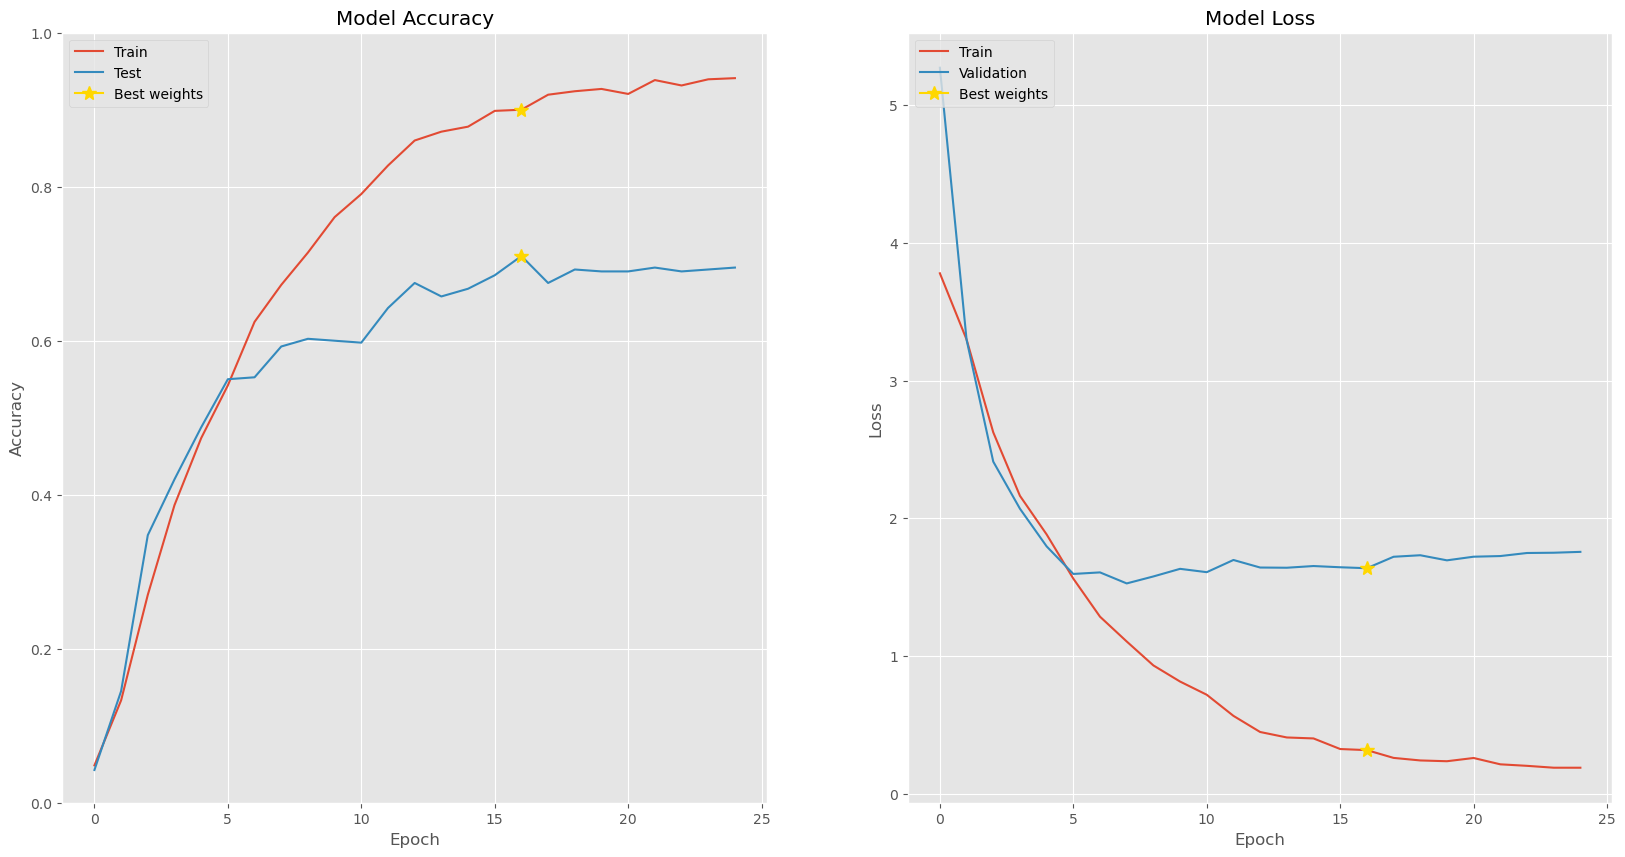

In [50]:
# Train the model and get the history and early stopping callback
history_ex_2, estop_ex_2 = run_experiment(generate_mel_spectrogram, augment=0.25)

# Save the trained model
model_file_path = './model/experiment_2_model.keras'
history_ex_2.model.save(model_file_path)

# Plot training curves (optional)
plot_curves(history_ex_2, estop=estop_ex_2).show()

# Print a message indicating that the model has been saved
print(f"Model saved to: {model_file_path}")


In [68]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(model_file_path)

# Print the summary of the loaded model
print("Model Summary:")
print(loaded_model.summary())


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 128, 216, 1)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 216, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 108, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 108, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 54, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 27, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 13, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26624)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,816,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          12,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,366,808 (89.14 MB)

 Trainable params: 7,788,850 (29.71 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 15,577,702 (59.42 MB)

None


TypeError: Invalid file: array([0.00060982, 0.00126945, 0.00120567, ..., 0.00097295, 0.00076881,
       0.00048158], dtype=float32)

In [54]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

# Function to record audio for a specified duration
def record_audio(duration, file_path):
    print("Recording...")
    # Start recording
    audio_data = sd.rec(int(duration * 44100), samplerate=44100, channels=1, dtype='int16')
    # Wait for recording to complete
    sd.wait()
    # Save the recorded audio to a WAV file
    wav.write(file_path, 44100, audio_data)
    print(f"Audio recorded and saved to {file_path}")

# Record a 5-second audio clip
file_path = 'output.wav'
record_audio(5, file_path)


Recording...
Audio recorded and saved to output.wav


In [82]:
import librosa
import numpy as np
import tensorflow as tf

# Label dictionary to map class index to category
labels_dict = {
    0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm',
    30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping',
    48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click',
    17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops',
    46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind',
    25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn',
    12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain',
    7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing',
    20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking',
    28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine',
    38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren',
    5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'
}

# Function to preprocess audio file into spectrogram
def preprocess_audio_file(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    # Generate mel spectrogram
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    # Resize spectrogram to match the input shape of the model
    shape = (1, melspec.shape[0], melspec.shape[1], 1)
    melspec = np.resize(melspec, shape)
    return melspec

# Function to make predictions using the trained model
def predict_with_model(model, file_path):
    # Preprocess audio file
    preprocessed_data = preprocess_audio_file(file_path)
    # Make prediction using the trained model
    prediction = model.predict(preprocessed_data)
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    # Map the predicted class index to category using label dictionary
    predicted_category = labels_dict.get(predicted_class_index, "Unknown")
    return predicted_category

# Load the trained model
model_file_path = 'model/experiment_2_model.keras'
model = tf.keras.models.load_model(model_file_path)

# Test the model with new data (e.g., output.wav)
file_path = 'output.wav'
predicted_category = predict_with_model(model, file_path)
print("Predicted Category:", predicted_category)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Category: dog


In [83]:
# Reshape the spectrograms to match the input shape of the model
X_test = X_test.reshape(-1, 128, 216, 1)

# Predict labels for the test data
y_pred = model.predict(X_test)

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=labels_dict.values())

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step
Confusion Matrix:
[[8 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 6]]

Classification Report:
                  precision    recall  f1-score   support

             dog       0.73      1.00      0.84         8
  chirping_birds       1.00      1.00      1.00         8
  vacuum_cleaner       1.00      0.38      0.55         8
    thunderstorm       0.89      1.00      0.94         8
 door_wood_knock       0.73      1.00      0.84         8
     can_opening       0.80      0.50      0.62         8
            crow       0.83      0.62      0.71         8
        clapping       0.62      0.62      0.62         8
       fireworks       1.00      0.88      0.93         8
        chainsaw       0.88      0.88      0.88         8
        airplane       0.86      0.75      0.80         8
     mouse_click       0.83      0.62      0.71         8
   pouring_water       0.71      0.62     

In [57]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Labels dictionary
labels_dict = {
    0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm',
    30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping',
    48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click',
    17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops',
    46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind',
    25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn',
    12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain',
    7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing',
    20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking',
    28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine',
    38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren',
    5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'
}

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
encoded_labels = label_encoder.fit_transform(list(labels_dict.values()))

# Save the label encoder to a file
joblib.dump(label_encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the label encoder
label_encoder = joblib.load('label_encoder.joblib')

# Function to preprocess audio file into spectrogram
def preprocess_audio_file(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    # Generate mel spectrogram
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    # Resize spectrogram to match the input shape of the model
    shape = (1, melspec.shape[0], melspec.shape[1], 1)
    melspec = np.resize(melspec, shape)
    return melspec

# Function to make predictions using the trained model
def predict_with_model(model, file_path):
    # Preprocess audio file
    preprocessed_data = preprocess_audio_file(file_path)
    # Make prediction using the trained model
    prediction = model.predict(preprocessed_data)
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    # Map the predicted class index to category using the label encoder
    predicted_category = label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_category

# Load the trained model
model = tf.keras.models.load_model(model_file_path)

# Test the model with new data (e.g., output.wav)
file_path = 'output.wav'
predicted_category = predict_with_model(model, file_path)
print("Predicted Category:", predicted_category)


In [ ]:
import numpy as np
import librosa
from tensorflow import keras
import joblib
import pickle
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import sys

#replace with your path to the label
labelencoder_src='label_encoder.joblib'
#replace with your audio file path
filename='1-12654-B-15.wav'

# Load the trained model
model_path = './model/experiment_2_model.keras'
model = load_model(model_path)

loaded_label_encoder = joblib.load(labelencoder_src)
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

# Example usage for prediction

mel_spectrogram_db = features_extractor(filename)
mel_spectrogram_db = mel_spectrogram_db.reshape(1, mel_spectrogram_db.shape[0], mel_spectrogram_db.shape[1], 1)

# Make predictions
raw_predictions = model.predict(mel_spectrogram_db)
predicted_label = np.argmax(raw_predictions)

print("Predicted Class:", predicted_class)


In [ ]:
def run_experiment(make_spec, augment=0):

  images_train = np.array([make_spec(clip,sr) for clip in train_audio])
  images_test =  np.array([make_spec(clip,sr) for clip in test_audio])

  num_augmented = int(len(train_audio)*augment)
  if augment:
    #genreate augmented images from the first num_augmented clips and concatenate them to the train images
    augmented_img = np.array([make_spec(audio_augment(samples=clip, sample_rate=sr),sr) for clip in train_audio[:num_augmented]])
    images_train = np.concatenate((images_train, augmented_img))


  #expected shape (num_examples, spec freq range, spec time, 1)
  shape_train = (len(images_train), images_train[0].shape[0], images_train[0].shape[1], 1)
  shape_test = (len(images_test), images_train[0].shape[0], images_train[0].shape[1], 1)
  images_train = np.resize(images_train, shape_train)
  images_test = np.resize(images_test, shape_test)

  labels_train = np.array(train_labels+train_labels[:num_augmented])
  labels_test = np.array(test_labels)

  model = build_model(shape_train[1:])

  model.summary()

  history = model.fit(images_train, labels_train, epochs=40, validation_data=(images_test,labels_test), callbacks=[rlronp,estop])

  return history, estop




In [ ]:
# Run the experiment
history, estop = run_experiment(generate_mel_spectrogram, augment=0)

# Make predictions on the testing data
y_pred = model.predict(images_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred_labels))

# Generate and print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_labels))


In [ ]:
import sounddevice as sd
import soundfile as sf

# Function to record audio
def record_audio(output_file, duration, sample_rate=44100):
    print("Recording audio...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()
    sf.write(output_file, audio_data, sample_rate)
    print(f"Audio recorded and saved to {output_file}")

# Recording duration in seconds
record_duration = 5

# Output file for recorded audio
output_file = 'output_processed.wav'

# Record audio
record_audio(output_file, record_duration)

In [ ]:
import librosa
import numpy as np
import tensorflow as tf

# Load the trained model
model_path = './model/experiment_2_model.h5'  # Replace with your model path
model = tf.keras.models.load_model(model_path)

# Load the recorded audio file
output_file = 'output_processed.wav'  # Replace with your recorded audio file path
y, sr = librosa.load(output_file, sr=None)

# Generate mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
mel_spec_input = mel_spec_db[np.newaxis, ..., np.newaxis]  # Add batch and channel dimension

# Make prediction
prediction = model.predict(mel_spec_input)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Display the predicted class index
print(f"Predicted Class Index: {predicted_class_index}")


In [ ]:
# Experiment #1: Mel Spectrograms, No augmentation

def generate_mel_spectrogram(y,sr):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    return melspec

history_ex_1, estop_ex_1 = run_experiment(generate_mel_spectrogram, augment=0)
plot_curves(history_ex_1, estop=estop_ex_1).show()

In [ ]:
# Experiment #1: Mel Spectrograms, No augmentation

def generate_mel_spectrogram(y,sr):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melspec = librosa.power_to_db(melspec, ref=np.max)
    return melspec

#history_ex_1, estop_ex_1 = run_experiment(generate_mel_spectrogram, augment=0)
#plot_curves(history_ex_1, estop=estop_ex_1).show()

In [ ]:
history_ex_2, estop_ex_2 = run_experiment(generate_mel_spectrogram, augment=.25)

plot_curves(history_ex_2, estop=estop_ex_2).show()

In [ ]:
history_ex_3, estop_ex_3 = run_experiment(generate_mel_spectrogram, augment=.5)

plot_curves(history_ex_3, estop=estop_ex_3).show()

In [ ]:
history_ex_4, estop_ex_4 = run_experiment(generate_mel_spectrogram, augment=1)

plot_curves(history_ex_4, estop=estop_ex_4).show()

In [ ]:
def generate_mfcc(y,sr):
  return librosa.feature.mfcc(y=y,sr=sr, n_fft=2048, hop_length=512, n_mfcc=20)

#mfcc_ex_5, estop_ex_5 = run_experiment(generate_mfcc, augment=0)
#plot_curves(mfcc_ex_5, estop=estop_ex_5).show()

In [ ]:
#mfcc_ex_6, estop_ex_6 = run_experiment(generate_mfcc, augment=.25)

plot_curves(mfcc_ex_6).show()

In [ ]:
mfcc_ex_7, estop_ex_7 = run_experiment(generate_mfcc, augment=.5)

plot_curves(mfcc_ex_7, estop=estop_ex_7).show()

In [ ]:
mfcc_ex_8, estop_ex_8 = run_experiment(generate_mfcc, augment=1)

plot_curves(mfcc_ex_8, estop=estop_ex_8).show()

In [ ]:
def generate_tempogram(y,sr):
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length= 512, norm=None)
    return tempogram

#history_ex_9, estop_ex_9 = run_experiment(generate_tempogram, augment=0)
#plot_curves(history_ex_9, estop=estop_ex_9).show()


In [ ]:
history_ex_10, estop_ex_10 = run_experiment(generate_tempogram, augment=.25)
plot_curves(history_ex_10, estop=estop_ex_10).show()


In [ ]:
history_ex_11, estop_ex_11 = run_experiment(generate_tempogram, augment=.5)
plot_curves(history_ex_11, estop=estop_ex_11).show()


In [ ]:
history_ex_12, estop_ex_12 = run_experiment(generate_tempogram, augment=1)
plot_curves(history_ex_12, estop=estop_ex_12).show()


In [ ]:
def generate_chromagram(y,sr):
  return librosa.feature.chroma_stft(y=y,sr=sr,n_fft=2048,hop_length=512, n_chroma=24)

#history_ex_13, estop_ex_13 = run_experiment(generate_chromagram, augment=0)
#plot_curves(history_ex_13, estop=estop_ex_13).show()

In [ ]:
history_ex_14, estop_ex_14 = run_experiment(generate_chromagram, augment=.25)
plot_curves(history_ex_14, estop=estop_ex_14).show()

In [ ]:
history_ex_15, estop_ex_15 = run_experiment(generate_chromagram, augment=.5)
plot_curves(history_ex_15, estop=estop_ex_15).show()

In [ ]:
history_ex_16, estop_ex_16 = run_experiment(generate_chromagram, augment=1)
plot_curves(history_ex_16, estop=estop_ex_16).show()

In [ ]:
def make_stacked_spec(y,sr, spec_generators, scale = False):
  #make each spec
  specs = [spec_gen(y,sr) for spec_gen in spec_generators]
  #find the tallest height
  heights = np.array([spec.shape[0] for spec in specs])
  tallest = np.argmax(heights)
  stacked_specs = []
  for spec in specs:
    if scale:
      spec = np.array(Image.fromarray(spec).resize(specs[tallest].shape))
    else:
      #insert copies of the spec until it's over the tallest height
      while spec.shape[0] < specs[tallest].shape[0]:
        spec = np.vstack((spec,spec))
      #trim off the top edge
      spec = spec[0:specs[tallest].shape[0],:]
    stacked_specs.append(spec)
  # dstack each spec
  stacked_spec = np.dstack([spec for spec in stacked_specs])
  return stacked_spec

In [ ]:
def run_experiment_stacked_specs(spec_generators, augment=0):

  num_channels = len(spec_generators)
  
  images_train = np.array([make_stacked_spec(clip,sr, spec_generators) for clip in train_audio])
  images_test =  np.array([make_stacked_spec(clip,sr, spec_generators) for clip in test_audio])

  num_augmented = int(len(train_audio)*augment)
  if augment:
    #genreate augmented images from the first num_augmented clips and concatenate them to the train images
    augmented_img = np.array([make_stacked_spec(audio_augment(samples=clip, sample_rate=sr),sr, spec_generators) for clip in train_audio[:num_augmented]])
    images_train = np.concatenate((images_train, augmented_img))


  #expected shape (num_examples, spec freq range, spec time, 1)
  shape_train = (len(images_train), images_train[0].shape[0], images_train[0].shape[1], num_channels)
  shape_test = (len(images_test), images_train[0].shape[0], images_train[0].shape[1], num_channels)
  images_train = np.resize(images_train, shape_train)
  images_test = np.resize(images_test, shape_test)

  labels_train = np.array(train_labels+train_labels[:num_augmented])
  labels_test = np.array(test_labels)

  model = build_model(shape_train[1:])

  model.summary()

  history = model.fit(images_train, labels_train, epochs=40, validation_data=(images_test,labels_test), callbacks=[rlronp,estop])

  return history, estop

In [ ]:
#melspecs and tempograms
history_ex_17, estop_ex_17 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_tempogram], augment=0)

plot_curves(history_ex_17, estop=estop_ex_17).show()

In [ ]:
#melspecs, chromagrams, and  tempograms at 100% augmentation
history_ex_17, estop_ex_17 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_chromagram, generate_tempogram], augment=1)

plot_curves(history_ex_17, estop=estop_ex_17).show()

In [ ]:
#melspecs and  tempograms at 100% augmentation
history_ex_18, estop_ex_18 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_tempogram], augment=1)

plot_curves(history_ex_18, estop=estop_ex_18).show()

In [ ]:
#melspecs and  chromagrams at 100% augmentation
history_ex_19, estop_ex_19 = run_experiment_stacked_specs([generate_mel_spectrogram, generate_chromagram], augment=1)

plot_curves(history_ex_19, estop=estop_ex_19).show()